<a href="https://colab.research.google.com/github/verneh/diffusion/blob/main/diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Me going through the Huggingface tutorial.

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

     |████████████████████████████████| 524 kB 31.1 MB/s 
     |████████████████████████████████| 452 kB 75.1 MB/s 
     |████████████████████████████████| 5.8 MB 62.2 MB/s 
     |████████████████████████████████| 191 kB 72.7 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 36.0 MB 51 kB/s 
     |████████████████████████████████| 182 kB 77.8 MB/s 
     |████████████████████████████████| 132 kB 71.9 MB/s 
     |████████████████████████████████| 212 kB 71.8 MB/s 
     |████████████████████████████████| 127 kB 23.9 MB/s 
     |████████████████████████████████| 7.6 MB 51.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.1 which is incompatible.


In [30]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


git lfs to upload model checkpoints

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

import libraries

In [4]:
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np
import torch
import torch.nn.functional as F

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

Downloading:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/589 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/794 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/597 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

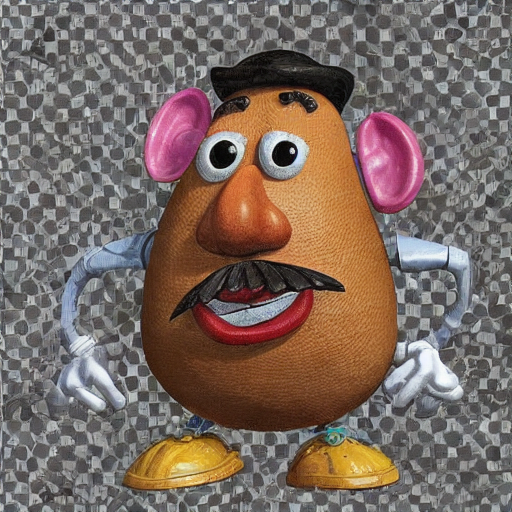

In [6]:
# Removed sks on the prompt. Tweak inference steps and guidance scale as low or as high as you want.
prompt = "an abstract watercolor of mr potato head by picasso"
image = pipe(prompt, num_inference_steps=30, guidance_scale=2.5).images[0]
image

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/267 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

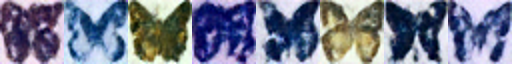

In [7]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

Test own dataset

In [8]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# dataset = load_dataset("imagefolder", data_dir="/content/magic")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


X shape: torch.Size([8, 3, 32, 32])


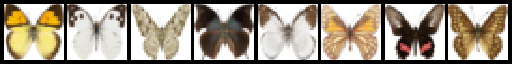

In [9]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

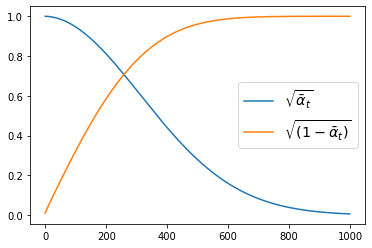

In [10]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");



In [11]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Noisy X shape torch.Size([8, 3, 32, 32])


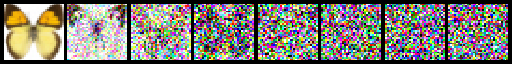

In [12]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [13]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [14]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

Training 
loop

In [15]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.14242559345439076
Epoch:10, loss: 0.11527004931122065
Epoch:15, loss: 0.09978051111102104
Epoch:20, loss: 0.08458346733823419
Epoch:25, loss: 0.08303496427834034
Epoch:30, loss: 0.07890103152021766


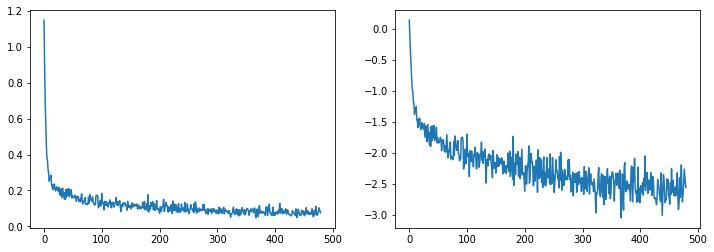

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [ ]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

In [17]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

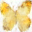

In [18]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [19]:
image_pipe.save_pretrained("my_pipeline")

In [20]:
!ls my_pipeline/

model_index.json  scheduler  unet


In [21]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


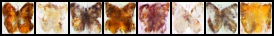

In [22]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [28]:
from huggingface_hub import get_full_repo_name

model_name = "test-sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'Verne/test-sd-class-butterflies-32'

In [31]:
from huggingface_hub import HfApi, create_repo

# you need to generate write access to token.
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/Verne/test-sd-class-butterflies-32/blob/main/model_index.json'

In [32]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/Verne/test-sd-class-butterflies-32/blob/main/README.md'

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]